In [1]:
from synet.networks import random_network
from synet.process import DelayProcess, DiseaseProcess, MajorityProcess, PredatorProcess
from synet.utils import apply_process, apply_measures
from pathlib import Path
import numpy as np
import pickle

In [2]:
n_events = 5000
n_agents = 100
n_communities = [1, 2, 3 ,4]
n_networks = 300
process_dt = 250
measure_dt = 100
n_jobs = 32

In [3]:
base_dir = Path("data")
base_dir.mkdir(exist_ok=True)

In [4]:
%%time
np.random.seed(1928374)
all_seeds = np.random.randint(0, 817934861, size=len(n_communities))
all_netsets = {}
for i_net, cur_comm in enumerate(n_communities):
    np.random.seed(all_seeds[i_net])
    name = f"a{n_agents}_e{n_events}_c{cur_comm}"
    net_fp = Path(base_dir, f"net_{name}.pkl")
    if net_fp.is_file():
        with open(net_fp, "rb") as f:
            all_netsets[name] = pickle.load(f)
        continue
    networks = [random_network(n_agents=n_agents, n_events=n_events, n_community=cur_comm)
                for _ in range(n_networks)]
    all_netsets[name] = networks
    with open(net_fp, "wb") as f:
        pickle.dump(networks, f)

CPU times: user 22.6 ms, sys: 92.2 ms, total: 115 ms
Wall time: 159 ms


In [5]:
processes = {
    "delay": {"process": DelayProcess(), "n_sim": 1000, "n_jobs": n_jobs},
    "majority": {"process": MajorityProcess(), "n_sim": 200, "n_jobs": n_jobs},
    "disease": {"process": DiseaseProcess(), "n_sim": 500, "n_jobs": n_jobs},
    "predator": {"process": PredatorProcess(), "n_sim": 1000, "n_jobs": n_jobs},
}

In [6]:
%%time

all_process_results = {}
for name, networks in all_netsets.items():
    process_fp = Path(base_dir, f"proc_{name}.pkl")
    try:
        with open(process_fp, "rb") as f:
            all_process_results[name] = pickle.load(f)
        continue
    except BaseException:
        pass

    process_results = {}
    for name, process_args in processes.items():
        res = apply_process(networks, dt=process_dt, **process_args)
        process_results[name] = res

    with open(process_fp, "wb") as f:
        pickle.dump(process_results, f)
    process_results[name] = process_results


CPU times: user 19.6 ms, sys: 2.02 s, total: 2.04 s
Wall time: 3 s


In [7]:
%%time

all_measure_results = {}
for name, networks in all_netsets.items():
    measure_fp = Path(base_dir, f"meas_{name}.pkl")
    try:
        with open(measure_fp, "rb") as f:
            all_measure_results[name] = pickle.load(f)
        continue
    except BaseException:
        pass
    measure_results = apply_measures(networks, max_dt=measure_dt, n_jobs=n_jobs)
    with open(measure_fp, "wb") as f:
        pickle.dump(measure_results, f)
    all_measure_results[name] = measure_results

CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 14.8 ms


In [8]:
# Add average results as a measure.

for net_name in all_netsets:
    process_results = all_process_results[net_name]
    n_network = len(process_results[list(process_results)[0]])
    avg_order = np.zeros(n_network)
    for proc_name, proc_res in process_results.items():
        avg_res = np.array([np.mean(r) for r in proc_res])
        order = np.argsort(avg_res)
        true_order = np.empty_like(order, dtype=int)
        true_order[order] = np.arange(len(order), dtype=int)

        avg_order += true_order/len(process_results)
    all_measure_results[net_name]["optimal"] = avg_order


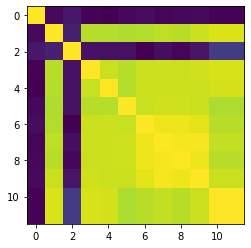

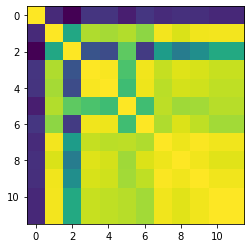

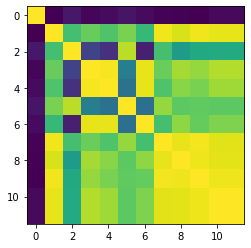

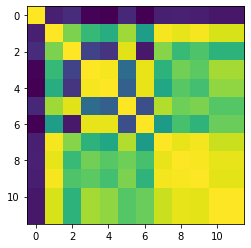

In [9]:
import pandas as pd
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from collections import defaultdict
def create_avg_results(process_results, measure_results):
    df = pd.DataFrame()
    n_network = len(process_results[list(process_results)[0]])
    df['net_id'] = np.arange(n_network)
    for name, res in process_results.items():
        cur_avg = np.array([np.mean(r) for r in res])
        df[name] = cur_avg
    for name, res in measure_results.items():
        df[name] = [np.mean(r) for r in res]
        

    return df


def add_best_results(df):
    df.drop("avg_order", errors="ignore")
    avg = np.zeros(len(df))
    for pr_name in list(df)[1:5]:
        order = np.argsort(df[pr_name].values)
        true_order = np.empty_like(order, dtype=int)
        true_order[order] = np.arange(len(order), dtype=int)

        avg += true_order

    new_order = avg/4
    df["avg_order"] = new_order
    return df


def create_cor_matrix(df):
    n_list = len(list(df))

    cor_matrix = np.zeros((n_list, n_list))
    for i_1, name_1 in enumerate(list(df)):
        for i_2, name_2 in enumerate(list(df)):
            cor_matrix[i_1, i_2] = spearmanr(df[name_1], df[name_2]).correlation
    return cor_matrix


def avg_measure_cor(cor_matrix, names):
    # measures
    res = {}
    for col in range(5, len(names)):
        avg = np.mean(cor_matrix[col, 1:5])
        res[names[col]] = avg
    return res

def avg_process_cor(cor_matrix, names):
    # processes
    res = {}
    for col in range(1, 5):
        avg = (np.sum(cor_matrix[col, 1:5])-1)/3
        res[names[col]] = avg
    return res

proc_avg_res = defaultdict(lambda: 0)
meas_avg_res = defaultdict(lambda: 0)
all_df = []
for name in all_netsets:
    df = create_avg_results(all_process_results[name], all_measure_results[name])
    df = add_best_results(df)
    cor_matrix = create_cor_matrix(df)
    proc_res = avg_process_cor(cor_matrix, list(df))
    meas_res = avg_measure_cor(cor_matrix, list(df))
    for proc_name, cur_res in proc_res.items():
        proc_avg_res[proc_name] += cur_res/len(all_netsets)
    for meas_name, cur_res in meas_res.items():
        meas_avg_res[meas_name] += cur_res/len(all_netsets)
    all_df.append(df)
    plt.imshow(cor_matrix)
    plt.show()

In [10]:
from pprint import pprint
pprint(dict(proc_avg_res))
pprint(dict(meas_avg_res))
print(np.mean([x for x in proc_avg_res.values()]))

{'delay': 0.6941810464560717,
 'disease': 0.6327635121871724,
 'majority': 0.2542810105297466,
 'predator': 0.611994429567736}
{'agent': 0.6681058678429761,
 'avg_order': 0.8030678145989916,
 'mixing': 0.7609385937621529,
 'optimal': 0.8030678145989916,
 'overlap': 0.6544256325070279,
 'paint': 0.7737762086245401,
 'path': 0.7604385048722763}
0.5483049996851816


In [11]:
combined_df = pd.concat(all_df)
combined_df = add_best_results(combined_df)
cor_matrix = create_cor_matrix(combined_df)
proc_res = avg_process_cor(cor_matrix, list(combined_df))
meas_res = avg_measure_cor(cor_matrix, list(combined_df))
pprint(proc_res)
pprint(meas_res)

{'delay': 0.761824536963594,
 'disease': 0.6829550460901537,
 'majority': 0.34548410822841075,
 'predator': 0.6696616745198666}
{'agent': 0.7064595678329151,
 'avg_order': 0.8428351957629521,
 'mixing': 0.8149011413005028,
 'optimal': 0.781353883365847,
 'overlap': 0.7119343786039983,
 'paint': 0.820171330762422,
 'path': 0.8065831416554476}


In [12]:
from synet.bootstrap import create_process_bootstrap, create_xcor_boot_matrix, avg_correlations


results = {}
def add_results(results, new_result):
    if len(results) == 0:
        return new_result
    for meas_name in results:
        for bound_name in results[meas_name]:
            results[meas_name][bound_name].extend(new_result[meas_name][bound_name])
    return results

for netset_name, process_results in all_process_results.items():
    boot_results = create_process_bootstrap(process_results)
    xcor_matrix, cor_names = create_xcor_boot_matrix(boot_results, all_measure_results[netset_name])
    new_result = avg_correlations(xcor_matrix, cor_names[1])
    results = add_results(results, new_result)

[0.03635519091427039, 0.028350356764201015, 0.03171960094572553, 0.03040776985167792]
[0.03358926781192454, 0.02161163952967864, 0.0271337501989152, 0.024763661137904826]
[0.03437288521691581, 0.017821535648073657, 0.02765944262920147, 0.023386903212447598]
[0.03411173351042151, 0.017200802925899396, 0.024402204008203702, 0.022095646497634867]
[0.03407672998647413, 0.017239357642363125, 0.026153896595105038, 0.022953694746551893]
[0.03173822103541883, 0.014778931736150292, 0.0180427807662839, 0.017870726948286435]


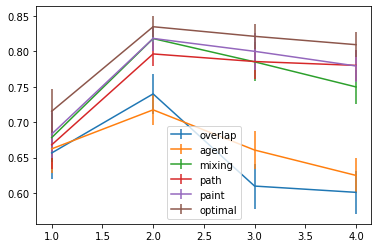

In [14]:
xarr = 1+np.arange(len(all_process_results))
for meas_name, res in results.items():
    yarr = np.array(res['median'])
    # yerr = np.abs(np.vstack((res['lower'], res['upper'])) - yarr)
    yerr = res["sem"]
    print(yerr)
    plt.errorbar(x=xarr, y=yarr, yerr=yerr, label=meas_name)
plt.legend()
plt.show()